# Introduction à la Science de Données
# TDM2 -  Classification : $k$ plus proches voisins et arbres de décision


La documentation Scikit-learn sur les $k$ plus proches voisins se trouve ici: http://scikit-learn.org/stable/modules/neighbors.html


Avant de commencer, vérifiez les versions des paquets Python:

In [3]:
import sys
import numpy as np # importation du package numérique
import matplotlib
import sklearn

print('python: {} (version 3 obligatoire)'.format(sys.version))
print('numpy: {} (version conseillée mais pas obligatoire: 1.9.0)'.format(np.__version__))
print('matplotlib: {} (version conseillée mais pas obligatoire: 3.6.0 au moins)'.format(matplotlib.__version__))
print('scikit-learn: {} (version conseillée mais pas obligatoire: 0.19 au moins)'.format(sklearn.__version__))

python: 3.11.5 (main, Sep 11 2023, 08:31:25) [Clang 14.0.6 ] (version 3 obligatoire)
numpy: 1.24.3 (version conseillée mais pas obligatoire: 1.9.0)
matplotlib: 3.7.2 (version conseillée mais pas obligatoire: 3.6.0 au moins)
scikit-learn: 1.4.2 (version conseillée mais pas obligatoire: 0.19 au moins)


Une version récente de Matplotlib est particulièrement souhaitable pour que l'affichage des images se fasse correctement, sans "lissage".

## 1. Données `digits` (obligatoire, sans rendu)

Dans la première partie de ce TDM, nous allons utiliser des données déjà présentes dans scikit-learn. Ces données (couramment appelées "MNIST") sont composées d'images de chiffres manuscrits à une résolution de $8\times 8$. En scikit-learn, elles se nomment `digits` : 

In [4]:
from sklearn.datasets import load_digits

digitsData=load_digits() # jeu de données digits
X=digitsData.data # les exemples, un array numpy, chaque élément est aussi un array
y=digitsData.target # les classes 

On peut regarder quelques informations :

In [8]:
print(X.dtype, X.shape)
print(y.dtype, y.shape)

float64 (1797, 64)
int64 (1797,)


Chaque donnée est donc une image de 8 pixels par 8 pixels, en niveau de gris (256 nuances possibles), stockée sous la forme d'un vecteur de dimension 64 comme une ligne de la matrice X (il y a 1797 images) et avec la valeur de la classe associée stockée dans un vecteur Y à part (comme pour Iris). On peut visualiser une des images du dataset :

Le vecteur de l'image d'indice 65 : [ 0.  0.  0.  9. 10.  0.  0.  0.  0.  0.  7. 16.  7.  0.  0.  0.  0.  0.
 13. 13.  1.  0.  0.  0.  0.  0. 15.  7.  0.  0.  0.  0.  0.  4. 16. 15.
 12.  7.  0.  0.  0.  2. 16. 12.  4. 11. 10.  0.  0.  0.  8. 14.  5.  9.
 14.  0.  0.  0.  0.  6. 12. 14.  9.  0.]
[[ 0.  0.  0.  9. 10.  0.  0.  0.]
 [ 0.  0.  7. 16.  7.  0.  0.  0.]
 [ 0.  0. 13. 13.  1.  0.  0.  0.]
 [ 0.  0. 15.  7.  0.  0.  0.  0.]
 [ 0.  4. 16. 15. 12.  7.  0.  0.]
 [ 0.  2. 16. 12.  4. 11. 10.  0.]
 [ 0.  0.  8. 14.  5.  9. 14.  0.]
 [ 0.  0.  0.  6. 12. 14.  9.  0.]]


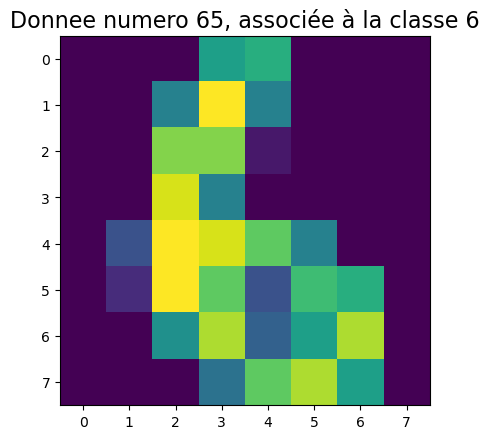

In [10]:
import matplotlib.pyplot as plt  # le package de visualisation
# Commande spéciale pour que afficher les images générées directement dans le jupyter notebook :
%matplotlib inline  

ix=65
donnee = X[ix,:] # on récupère toutes les colonnes de la ligne `ix`, donc une donnée
classe = y[ix]   # et sa classe
print("Le vecteur de l'image d'indice {} : {}".format(ix, donnee))

image = donnee.reshape(8,8) # on met les 8 morceaux de taille 8 du vecteur les uns en dessous des autres pour former une matrice
print(image)                     # on affiche la matrice de pixels au terminal
plt.imshow(image)                # on affiche l'image qui lui correspond graphiquement
plt.title('Donnee numero {}, associée à la classe {}'.format(ix, classe), fontsize=16) # avec un titre
plt.show()

On peut faire des affichages plus complets, exemple sur les 5 premières données :

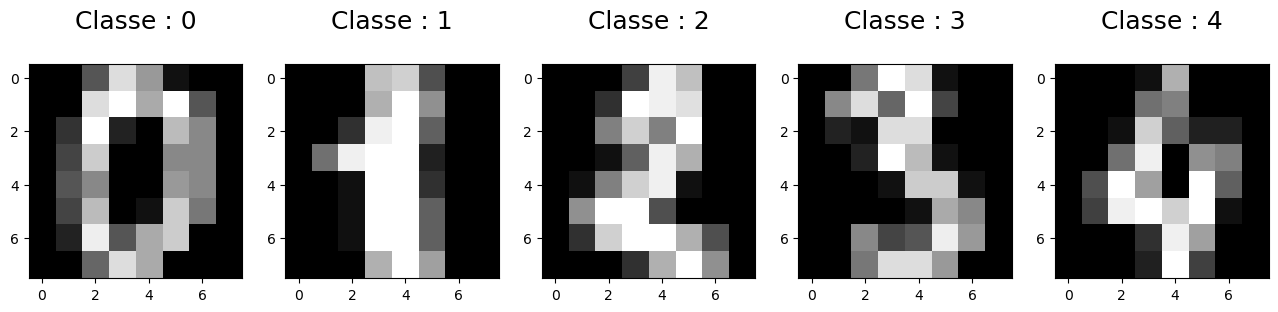

In [10]:
plt.figure(figsize=(16,4))
for index in range(5):
  debut = 0 
  donnee = X[debut + index, :]
  classe = y[debut + index]
  plt.subplot(1, 5, index + 1)
  plt.imshow(donnee.reshape(8,8), cmap=plt.cm.gray)
  plt.title('Classe : %i\n' % classe, fontsize = 18)
plt.show()

## 2. Création, entraînement et évaluation d'un classifieur (obligatoire, sans rendu)

Notre objectif est maintenant d'apprendre, sur la base d'un échantillon d'images "chiffres", un classifieur capable de prédire le chiffre qui correspond à une nouvelle image. Nous allons utiliser la méthode des $k$-plus proches voisins pour cet apprentissage. Elle est implémentée dans un package appelé `neighbors`. Examinons la série d'instructions suivante:

In [11]:
from sklearn import neighbors as nn # importation du package d'algorithmes travaillant sur les points voisins
help(nn.KNeighborsClassifier) # Cette methode help va nous aider a comprendre ce que la méthode fait ainsi que ses parametres 

Help on class KNeighborsClassifier in module sklearn.neighbors._classification:

class KNeighborsClassifier(sklearn.neighbors._base.KNeighborsMixin, sklearn.base.ClassifierMixin, sklearn.neighbors._base.NeighborsBase)
 |  KNeighborsClassifier(n_neighbors=5, *, weights='uniform', algorithm='auto', leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=None)
 |  
 |  Classifier implementing the k-nearest neighbors vote.
 |  
 |  Read more in the :ref:`User Guide <classification>`.
 |  
 |  Parameters
 |  ----------
 |  n_neighbors : int, default=5
 |      Number of neighbors to use by default for :meth:`kneighbors` queries.
 |  
 |  weights : {'uniform', 'distance'}, callable or None, default='uniform'
 |      Weight function used in prediction.  Possible values:
 |  
 |      - 'uniform' : uniform weights.  All points in each neighborhood
 |        are weighted equally.
 |      - 'distance' : weight points by the inverse of their distance.
 |        in this case, closer neighb

Sympa, non ? Ce type d'instruction est utilisable pour toute classe de Python. 

De même, les fonctions `predict` et `fit`, détaillées ci-dessous, existent **pour tous les classifieurs** disponibles dans scikit-learn.

### 2.1 Apprentissage du classifieur $k$ plus proches voisins

Continuons l'exploration de la classification avec l'algorithme des $k$ plus proches voisins. Dans la série d'instructions suivante, on indique comment créer un classifieur qui implémente ce modèle.

In [6]:
nb_voisins = 15 # on fixe le nombre de voisins, à partir de 2 et au max le nombre total d'exemples dans le jeu de données
clf = nn.KNeighborsClassifier(nb_voisins) 
clf # Le classifieur est instancié vide, il n'a pas encore été appris

KNeighborsClassifier(n_neighbors=15)

Le classifieur peut être appris à partir des données étiquetées du dataset `digits` avec la fonction `fit`.

In [13]:
clf.fit(X, y) # entraînement du classifieur clf sur les données étiquetées

KNeighborsClassifier(n_neighbors=15)

### 2.2 Prédiction avec le classifieur $k$ plus proches voisins

Les commandes ci-dessous illustrent comment réaliser la prédiction sur des exemples. On note ici la syntaxe de la fonction `predict`: on lui passe en réalité un tableau d'exemples (ici, un tableau avec un seul exemple constitué de 64 attributs), et elle renvoit un tableau contenant la classe prédite pour chaque exemple du tableau passé en paramètre. 

La correspondance entrées-sorties est gardée via les indices. C'est-à-dire, dans les tableaux en entrée et en sortie, les indices des classes prédites sont alignés avec les indices des exemples en entrée !

In [14]:
nouvel_ex = X[50, :]  # On extrait la 50e image du dataset
nouvel_ex_tableau = nouvel_ex.reshape(1,-1) # on doit ajouter une dimension car `predict` s'attend à une matrice 2D d'exemples
print("Vecteur shape={} devient tableau shape={}".format(nouvel_ex.shape, nouvel_ex_tableau.shape))
prediction = clf.predict(nouvel_ex_tableau)  # prédiction du modèle appris sur la description d'une image choisie au hasard
print('Prédiction pour le nouvel exemple: {} (type={})'.format(prediction, type(prediction)))

Vecteur shape=(64,) devient tableau shape=(1, 64)
Prédiction pour le nouvel exemple: [2] (type=<class 'numpy.ndarray'>)


Lorsque l'on sait que l'on n'applique `predict` qu'à un seul exemple, la sélection de l'indice `[0]`, comme ci-après, renvoie la première (et la seule) composante du tableau de résultats (notez que le résultat est affiché en tant qu'entier, pas en tant que vecteur à 1 élément).

In [15]:
print('prédiction pour le nouvel exemple: {} (type={})'.format(prediction[0], type(prediction[0])))

prédiction pour le nouvel exemple: 2 (type=<class 'numpy.int64'>)


Pour certains types de classifieurs, on peut même récupérer la probabilité que le classifieur attribue à l'appartenance de l'exemple à chaque classe possible. La fonction `predict_proba` fonctionne comme la fonction `predict`, sauf que le tableau en sortie contient, pour chaque exemple du tableau en entrée, un tableau de probabilités de la même taille que le nombre de classes.

In [16]:
autre_ex = X[123, :] # on génère un autre exemple en prenant une autre image
print(clf.predict_proba(nouvel_ex.reshape(1,-1))[0]) # probabilité d'appartenance à chaque classe pour ce chiffre
print(clf.predict_proba(autre_ex.reshape(1,-1))[0]) # idem pour un autre exemple

[0.  0.  0.8 0.  0.  0.  0.  0.  0.2 0. ]
[0.         0.46666667 0.         0.         0.         0.
 0.         0.         0.53333333 0.        ]


A votre avis, quelle classe sera attribuée au deuxième exemple, et pourquoi ? Indiquez ci-après l'instruction à exécuter pour vérifier. 

In [17]:
# A mon avis pour le deuxième exemple on attribuera la classe 8 car c'est celle avec la plus grande probabilité
autre_ex_tableau = autre_ex.reshape(1,-1) # on doit ajouter une dimension car `predict` s'attend à une matrice 2D d'exemples
print("Vecteur shape={} devient tableau shape={}".format(autre_ex.shape, autre_ex_tableau.shape))
prediction = clf.predict(autre_ex_tableau)  # prédiction du modèle appris sur la description d'une image choisie au hasard
print('Prédiction pour le nouvel exemple: {} (type={})'.format(prediction, type(prediction)))

Vecteur shape=(64,) devient tableau shape=(1, 64)
Prédiction pour le nouvel exemple: [8] (type=<class 'numpy.ndarray'>)


### 2.3 Évaluation du classifieur $k$ plus proches voisins

Une première façon d'évaluer la qualité d'un classifieur est de le tester sur les exemples qui ont servi à l'apprendre. On utilise la même fonction `predict`, appliquée au tableau des exemples d'apprentissage. 

In [18]:
f_X = clf.predict(X) # vecteur des classes prédites pour chaque exemple de l'ensemble d'apprentissage
print(X[f_X!=y]) # le tableau d'exemples (images) pour lesquels la prédiction a été mauvaise

[[ 0.  0. 12. ... 10.  0.  0.]
 [ 0.  0.  6. ...  0.  0.  0.]
 [ 0.  0.  0. ... 16. 12.  0.]
 ...
 [ 0.  0.  7. ...  0.  0.  0.]
 [ 0.  1.  7. ...  6.  0.  0.]
 [ 0.  0.  5. ...  3.  0.  0.]]


Pour vous rendre compte de l'origine possible des erreurs de prédiction, faites une boucle sur toutes les images pour lesquelles la prédiction est erronnée en affichant à chaque fois l'image 8x8 avec dans le titre l'indice de l'image, la classe originale et la classe prédite (pour cela, on peut utiliser la fonction `np.argwhere` avec un peu de jugeotte).

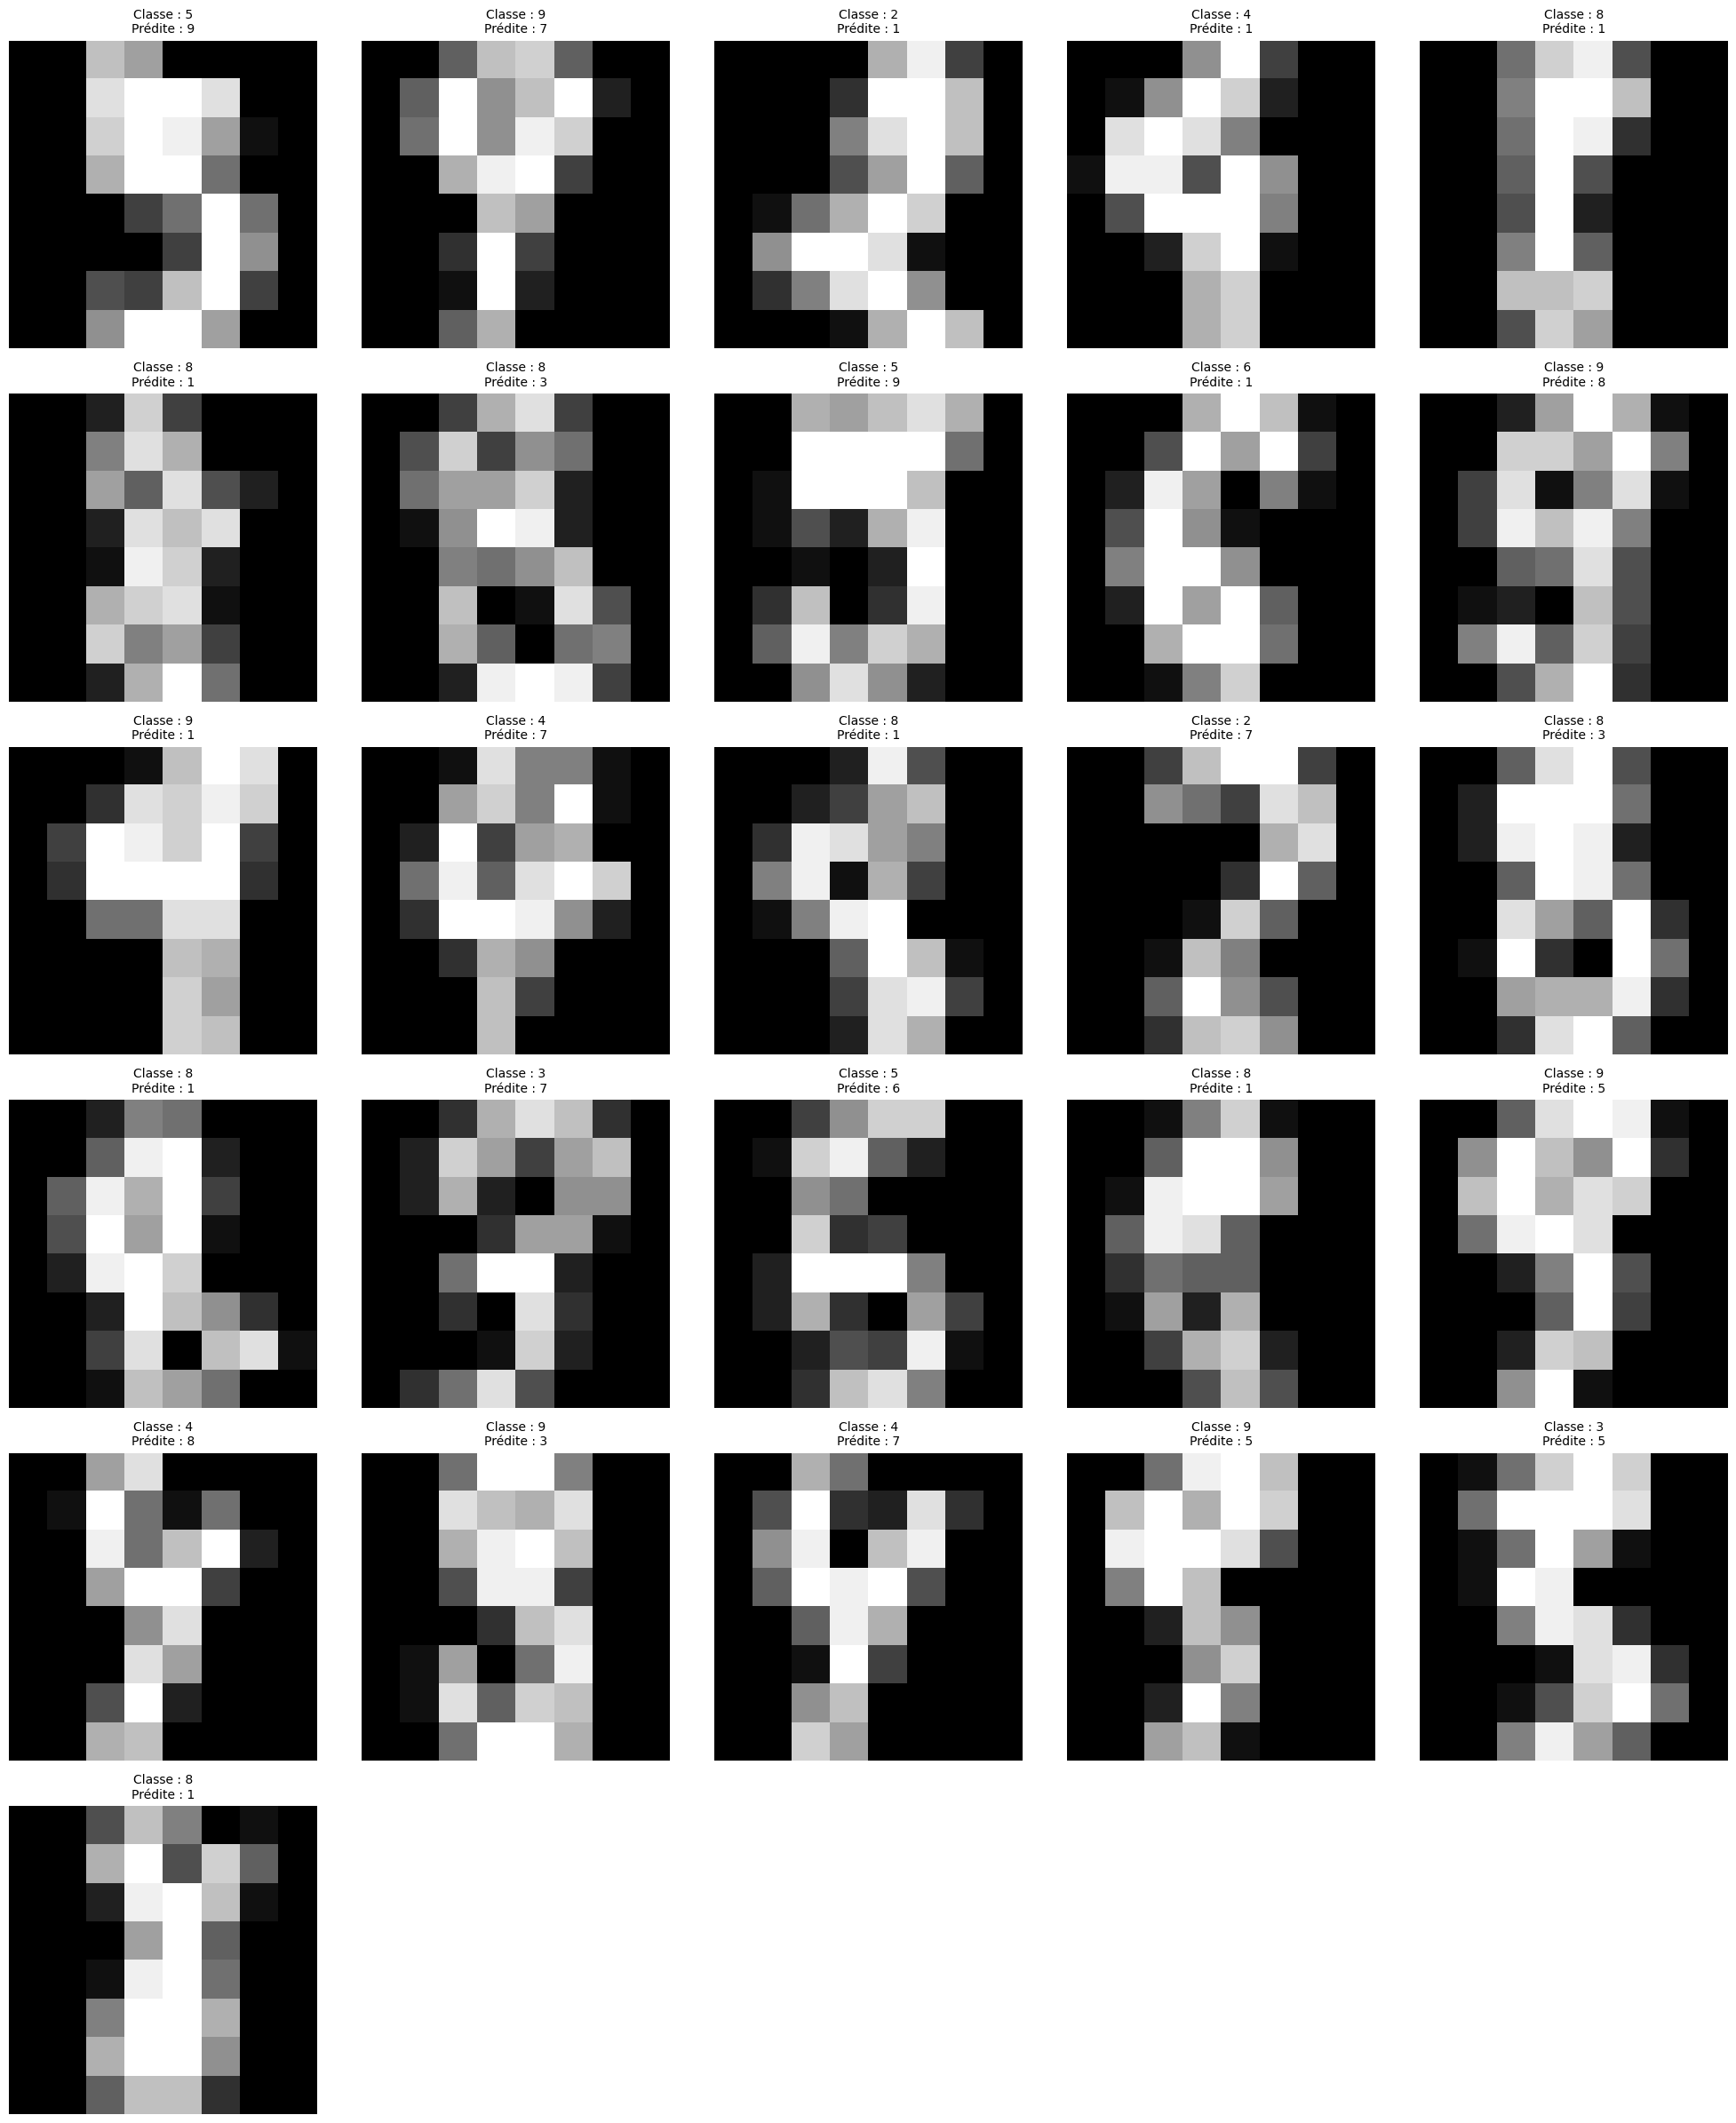

In [19]:
# Identifier les indices des images mal prédites
indices_mal_predits = np.where(f_X != y)[0]

# Nombre total d'images mal prédites
total_mal_predits = len(indices_mal_predits)

# Calculer le nombre de lignes nécessaires
n_colonnes = 5
n_lignes = (total_mal_predits + n_colonnes - 1) // n_colonnes  # Arrondi au supérieur

# Créer une figure avec un nombre dynamique de lignes et colonnes
plt.figure(figsize=(n_colonnes * 4, n_lignes * 4))  # Ajuster la taille pour plus d'images

for idx, i in enumerate(indices_mal_predits):
    donnee = X[i, :]              # Récupérer les données de l'image
    classe = y[i]                 # Classe réelle
    classe_predite = f_X[i]       # Classe prédite
    
    # Placer le sous-graphe dans la grille
    plt.subplot(n_lignes, n_colonnes, idx + 1)
    plt.imshow(donnee.reshape(8, 8), cmap=plt.cm.gray)  # Afficher l'image
    plt.title(f'Classe : {classe}\nPrédite : {classe_predite}', fontsize=10)
    plt.axis('off')  # Optionnel : ne pas afficher les axes

plt.tight_layout()  # Ajuster les sous-graphes pour qu'ils ne se chevauchent pas
plt.show()

Chaque classifieur possède une fonction score, qui permet de comparer les prédictions d'un ensemble d'exemples $X$ pour lesquelles on connaît les étiquettes $y$ : la fonction calcule le taux de bonne classifications. 

In [20]:
print ("Taux de bonne classification = {:.2f}%".format(clf.score(X,y)*100))
# taux de bonne classification du modèle sur l'ensemble d'apprentissage (car X et y sont les données d'apprentissage): fonction score

Taux de bonne classification = 98.55%


On la détourne facilement pour obtenir le taux d'erreur: faites le (vous devez obtenir 0.01446855...)!

In [21]:
# pour le taux d'erreur il suffit de faire ( 100 - score )/100
erreur = ((100 - (clf.score(X,y)*100))/100)
print("Taux d'erreur : " + format(erreur))

Taux d'erreur : 0.014468558708959307


## 3. Variation du nombre de voisins (à rendre dans rapport)

L'algorithme des $k$-plus proches voisins fonctionne avec plusieurs hyper-paramètres. Un **hyper-paramètre** est un paramètres de l'agorithme, pas du modèle appris: la valeur de $k$ est un de ces hyper-paramètres. 

**Question.** Réalisez un programme qui :
1. Fait varier cet hyper-paramètre dans un intervalle comprenant des valeurs entre 1 et 25
2. Pour chaque valeur dans cet intervalle, stocke l'évolution de l'erreur d'apprentissage (calculée sur l'échantillon d'apprentissage)
3. Trace une courbe avec, en abscisse, la valeur de $k$, et en ordonnées l'erreur correspondante sur l'échantillon d'apprentissage.

Pour les données en abscisse, on peut s'aider de la fonction de construction d'un tableau `numpy.arange` (cf. documentation). Pour tracer la courbe, on utilisera la fonction `plot(abs, ord)` du package `pyplot` de `matplotlib` (similaire à `scatter`, mais dessine une courbe au lieu de points isolés).

k = 1, erreur = 0.0
k = 2, erreur = 0.008903728436282694
k = 3, erreur = 0.00667779632721202
k = 4, erreur = 0.0077907623817473565
k = 5, erreur = 0.009460211463550361
k = 6, erreur = 0.01001669449081803
k = 7, erreur = 0.009460211463550361
k = 8, erreur = 0.010573177518085699
k = 9, erreur = 0.011129660545353366
k = 10, erreur = 0.014468558708959377
k = 11, erreur = 0.012242626599888704
k = 12, erreur = 0.012242626599888704
k = 13, erreur = 0.01335559265442404
k = 14, erreur = 0.013912075681691708
k = 15, erreur = 0.014468558708959377
k = 16, erreur = 0.015581524763494713
k = 17, erreur = 0.016138007790762382
k = 18, erreur = 0.016138007790762382
k = 19, erreur = 0.016138007790762382
k = 20, erreur = 0.017807456872565387
k = 21, erreur = 0.018363939899833055
k = 22, erreur = 0.018920422927100722
k = 23, erreur = 0.020589872008903727
k = 24, erreur = 0.021702838063439065
k = 25, erreur = 0.02448525319977741


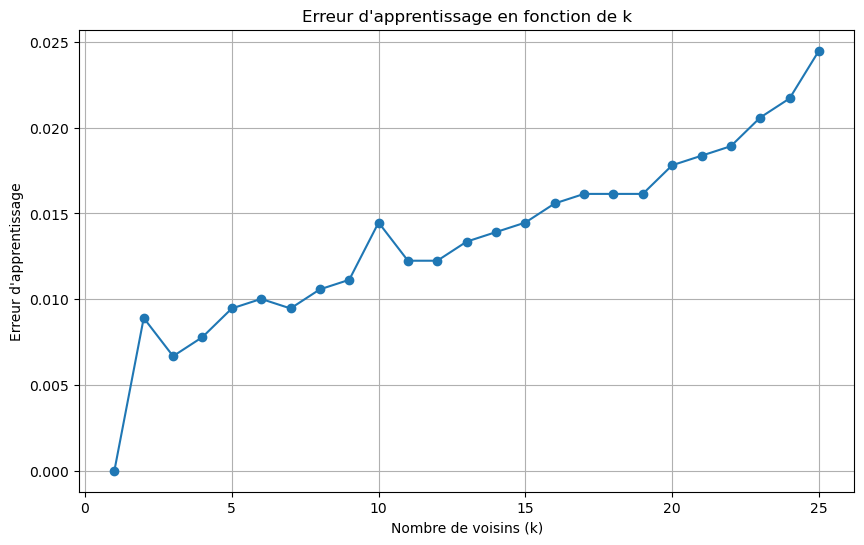

In [24]:
from sklearn.neighbors import KNeighborsClassifier

# Intervalle des valeurs de k
valeurs_k = np.arange(1, 26)  # Valeurs de 1 à 25
erreurs = []

# Boucle sur les valeurs de k
for k in valeurs_k:
    # Créer et entraîner le classifieur
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X, y)
    
    # Calculer les prédictions
    predictions = clf.predict(X)
    
    # Calculer l'erreur d'apprentissage
    erreur = np.mean(predictions != y)
    erreurs.append(erreur)
    print("k = " + str(k) + ", erreur = " + str(erreur))

# Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(valeurs_k, erreurs, marker='o')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Erreur d\'apprentissage')
plt.title('Erreur d\'apprentissage en fonction de k')
plt.grid(True)
plt.show()

**Questions.** Qu'observez-vous ? A quelle valeur de $k$ atteint-on un meilleur classifieur ? Quelle est globalement, sur ce jeu de données, l'influence de $k$ ? Que se passe-t-il exactement pour $k=1$ ?

## 4. Estimation de l'erreur réelle (à rendre dans rapport)

Lorsque le score du classifieur appris est évalué sur l'ensemble d'apprentissage, il est en général sur-estimé (pourquoi ?) et donc, très peu fiable. Pour évaluer un classifieur de manière plus réaliste, il est nécessaire de calculer son score sur un **échantillon test**, indépendant de l'échantillon d'apprentissage mais généré dans les mêmes conditions. 

### 4.1 Estimation sur données _hold-out_

Lorsque l'on dispose d'un seul ensemble d'exemples (comme c'est le cas de `digits`), la procédure usuelle est la suivante :

1. Répartir les données en un sous-ensemble d'apprentissage et un sous-ensemble test,
2. Entraîner un classifieur sur l'ensemble d'apprentissage 
3. Évaluer ce classifieur sur l'ensemble test

Avec cette méthode, on a une évaluation de l'erreur réelle, même si elle reste instable puisque dépendant du découpage effectué à l'étape 1. Si les données sont peu nombreuses, comme c'est le cas pour le jeu de données `digits`, cette évaluation risque d'être pessimiste. (avez-vous une idée de pourquoi ? Si oui, expliquez, sinon réfléchissez!).

Scikit-learn vient avec toute une panoplie d'outils pour évaluer cette erreur. Pour l'instant, nous n'utiliserons que la fonction qui permet de diviser un échantillon (attributs et classes) en deux sous-ensembles **disjoints**: c'est la fonction `train_test_split` du package `model_selection`. On spécifie la proportion de données dans chaque sous-ensemble, et la fonction sépare les données **au hasard** selon la proportion indiquée. Nous appliquons la fonction `train_test_split` ci-après sur `digits`. Ensuite, nous affichos les deux premiers exemples de chaque sous-échantillon, avec leurs étiquettes:

In [25]:
from sklearn.model_selection import train_test_split
# production de deux sous-échantillons
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.25, random_state=42)
print(Xtrain[:2,:].reshape(-1,8,8))
print(ytrain[:2])
print(Xtest[:2,:].reshape(-1,8,8))
print(ytest[:2])

[[[ 0.  0.  2. 15. 15. 16. 11.  0.]
  [ 0.  0.  8. 16. 11.  3.  0.  0.]
  [ 0.  0. 13.  9.  0.  0.  0.  0.]
  [ 0.  5. 16.  3.  9. 11.  3.  0.]
  [ 0. 10. 15. 15. 16. 16. 11.  0.]
  [ 0.  6. 16. 10.  7. 16.  5.  0.]
  [ 0.  0.  3.  4. 15.  8.  0.  0.]
  [ 0.  0.  4. 15.  7.  0.  0.  0.]]

 [[ 0.  5. 16. 15.  3.  0.  0.  0.]
  [ 0. 11. 14. 11. 11.  0.  0.  0.]
  [ 0.  8. 11.  4. 16.  0.  0.  0.]
  [ 0.  0.  0.  4. 13.  0.  0.  0.]
  [ 0.  0.  0.  8. 12.  0.  0.  0.]
  [ 0.  0.  0. 13.  9.  5.  1.  0.]
  [ 0.  1. 11. 16. 16. 16. 10.  0.]
  [ 0.  5. 16. 14.  8.  6.  1.  0.]]]
[5 2]
[[[ 0.  0.  0.  7. 12.  0.  0.  0.]
  [ 0.  0.  4. 16.  8.  0.  0.  0.]
  [ 0.  0. 12. 11.  0.  0.  0.  0.]
  [ 0.  0. 15. 10.  8.  6.  1.  0.]
  [ 0.  0. 15. 16.  8. 10.  8.  0.]
  [ 0.  0. 14.  7.  0.  0. 12.  0.]
  [ 0.  0.  8. 11.  0.  5. 16.  2.]
  [ 0.  0.  0.  9. 14. 14.  5.  0.]]

 [[ 0.  0. 11. 16.  8.  0.  0.  0.]
  [ 0.  6. 16. 11. 13.  9.  0.  0.]
  [ 0.  7. 16.  0.  9. 16.  0.  0.]
  [ 0.  2. 15. 1

Ici, nous produisons un découpage dans lequel l'ensemble d'apprentissage représente 75% de l'échantillon initial, et l'échantillon de test représente 25% des données initiales.

Le rôle du paramètre `random_state` est d'initialiser le processus de génération de nombres aléatoires. Deux appels successifs de la fonction `train_test_split` avec la même valeur de `random_state` et `test_split` créent une séparation du jeu de données identique, car l'initialisation de la sélection aléatoire est la même. 

**Question.** Pour illustrer l'influence du `random_state`, réalisez un second appel avec les mêmes paramètres et vérifiez les premiers éléments des tableaux obtenus, qui doivent être similaires à ceux ci-avant. Ensuite, réalisez un troisième appel avec une autre valeur pour `random_state`, et vérifier à nouveau les premiers éléments des tableaux pour constater qu'ils ont changé.

In [26]:
# Deuxième appel avec la même valeur de random_state
Xtrain2, Xtest2, ytrain2, ytest2 = train_test_split(X, y, test_size=0.25, random_state=42)

# Affichage des premiers exemples pour le deuxième appel
print("\nDeuxième appel avec random_state=42 :")
print("Ensemble d'apprentissage (premiers exemples) :")
print(Xtrain2[:2, :].reshape(-1, 8, 8))
print("Étiquettes de l'ensemble d'apprentissage :")
print(ytrain2[:2])
print("Ensemble de test (premiers exemples) :")
print(Xtest2[:2, :].reshape(-1, 8, 8))
print("Étiquettes de l'ensemble de test :")
print(ytest2[:2])

# Troisième appel avec une autre valeur de random_state
Xtrain3, Xtest3, ytrain3, ytest3 = train_test_split(X, y, test_size=0.25, random_state=99)

# Affichage des premiers exemples pour le troisième appel
print("\nTroisième appel avec random_state=99 :")
print("Ensemble d'apprentissage (premiers exemples) :")
print(Xtrain3[:2, :].reshape(-1, 8, 8))
print("Étiquettes de l'ensemble d'apprentissage :")
print(ytrain3[:2])
print("Ensemble de test (premiers exemples) :")
print(Xtest3[:2, :].reshape(-1, 8, 8))
print("Étiquettes de l'ensemble de test :")
print(ytest3[:2])


Deuxième appel avec random_state=42 :
Ensemble d'apprentissage (premiers exemples) :
[[[ 0.  0.  2. 15. 15. 16. 11.  0.]
  [ 0.  0.  8. 16. 11.  3.  0.  0.]
  [ 0.  0. 13.  9.  0.  0.  0.  0.]
  [ 0.  5. 16.  3.  9. 11.  3.  0.]
  [ 0. 10. 15. 15. 16. 16. 11.  0.]
  [ 0.  6. 16. 10.  7. 16.  5.  0.]
  [ 0.  0.  3.  4. 15.  8.  0.  0.]
  [ 0.  0.  4. 15.  7.  0.  0.  0.]]

 [[ 0.  5. 16. 15.  3.  0.  0.  0.]
  [ 0. 11. 14. 11. 11.  0.  0.  0.]
  [ 0.  8. 11.  4. 16.  0.  0.  0.]
  [ 0.  0.  0.  4. 13.  0.  0.  0.]
  [ 0.  0.  0.  8. 12.  0.  0.  0.]
  [ 0.  0.  0. 13.  9.  5.  1.  0.]
  [ 0.  1. 11. 16. 16. 16. 10.  0.]
  [ 0.  5. 16. 14.  8.  6.  1.  0.]]]
Étiquettes de l'ensemble d'apprentissage :
[5 2]
Ensemble de test (premiers exemples) :
[[[ 0.  0.  0.  7. 12.  0.  0.  0.]
  [ 0.  0.  4. 16.  8.  0.  0.  0.]
  [ 0.  0. 12. 11.  0.  0.  0.  0.]
  [ 0.  0. 15. 10.  8.  6.  1.  0.]
  [ 0.  0. 15. 16.  8. 10.  8.  0.]
  [ 0.  0. 14.  7.  0.  0. 12.  0.]
  [ 0.  0.  8. 11.  0.  5. 16.

**Question.** En vous inspirant de ce mode de découpage, écrire une séquence d'instructions permettant de séparer *digits* en deux parties égales, d'apprendre un 3-plus proches voisins sur le premier sous-échantillon, et de le tester sur le second: vous obtenez une **estimation** de l'erreur réelle. Obtenez-vous la même erreur que celle d'apprentissage mesurée précédemment ?

In [27]:
from sklearn.metrics import accuracy_score
from sklearn import datasets 

# Chargement des données
digits = datasets.load_digits()

# Division des données en deux parties égales (50% pour l'entraînement, 50% pour le test)
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.5, random_state=42)

# Création et entraînement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Prédiction et calcul de l'erreur sur l'ensemble de test
y_test_pred = knn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_error = 1 - test_accuracy

# Affichage de l'erreur réelle 
print(f"Erreur réelle: {test_error}")


Erreur réelle: 0.013348164627363768


**Question.** Faites maintenant à nouveau varier $k$ comme dans l'exercice 3. Pour chaque valeur de $k$, indiquez l'erreur réelle estimée sur la base d'un `train_test_split` de 70%/30%. Finalement, tracez la courbe de l'erreur réelle en fonction de la valeur de $k$. Observez-bien les différences de valeurs des erreurs d'apprentissage et réelle : pourquoi sont-elles différentes ? Que constatez-vous ?

k = 1, erreur = 0.01666666666666672
k = 2, erreur = 0.01666666666666672
k = 3, erreur = 0.011111111111111072
k = 4, erreur = 0.012962962962962954
k = 5, erreur = 0.007407407407407418
k = 6, erreur = 0.005555555555555536
k = 7, erreur = 0.0092592592592593
k = 8, erreur = 0.012962962962962954
k = 9, erreur = 0.01851851851851849
k = 10, erreur = 0.01851851851851849
k = 11, erreur = 0.020370370370370372
k = 12, erreur = 0.022222222222222254
k = 13, erreur = 0.022222222222222254
k = 14, erreur = 0.024074074074074026
k = 15, erreur = 0.024074074074074026
k = 16, erreur = 0.024074074074074026
k = 17, erreur = 0.022222222222222254
k = 18, erreur = 0.025925925925925908
k = 19, erreur = 0.02777777777777779
k = 20, erreur = 0.024074074074074026
k = 21, erreur = 0.02777777777777779
k = 22, erreur = 0.02777777777777779
k = 23, erreur = 0.02777777777777779
k = 24, erreur = 0.033333333333333326
k = 25, erreur = 0.033333333333333326


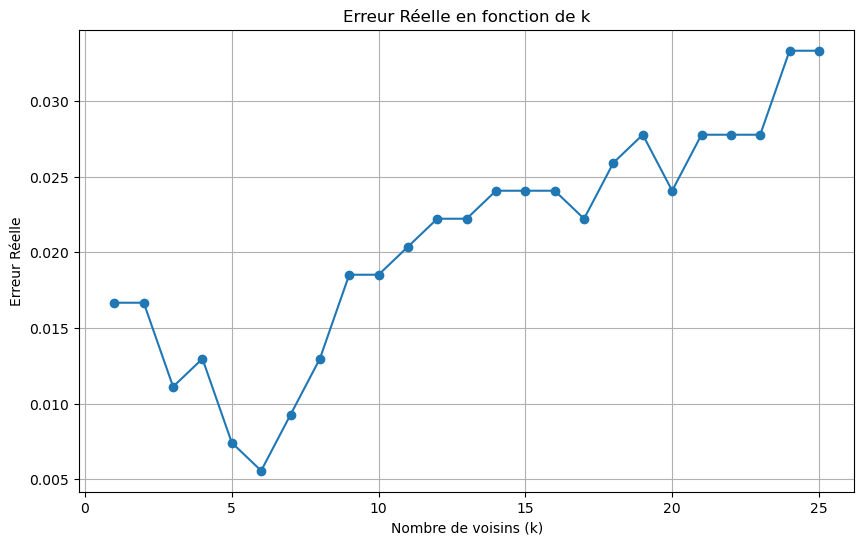

In [28]:
# Intervalle des valeurs de k
valeurs_k = np.arange(1, 26)  # Valeurs de 1 à 25
erreurs = []

# Division des données en deux parties (70% pour l'entraînement, 30% pour le test)
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.3, random_state=42)

# Boucle sur les valeurs de k
for k in valeurs_k:
    # Créer et entraîner le classifieur
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    
    # Calculer les prédictions
    predictions = clf.predict(X_test)
    
    # Calculer l'erreur d'apprentissage
    test_accuracy = accuracy_score(y_test, predictions)
    test_error = 1 - test_accuracy
    erreurs.append(test_error)
    print("k = " + str(k) + ", erreur = " + str(test_error))

# Tracer la courbe
plt.figure(figsize=(10, 6))
plt.plot(valeurs_k, erreurs, marker='o')
plt.xlabel('Nombre de voisins (k)')
plt.ylabel('Erreur Réelle')
plt.title('Erreur Réelle en fonction de k')
plt.grid(True)
plt.show()

L'évaluation sur données _hold-out_ mène à une estimation de l'erreur réaliste, mais qui dépend fortement de l'ensemble d'entraînemnet et de l'ensemble de test, obtenus au hasard. Nous contrôlons uniquement la taille des données de test (proportion des données originelles) mais la sélection des données est aléatoire.

Une trop forte dépendance à une partition spécifique des données mène à une estimation potentiellement biaisée. Afin d'éviter ce risque, l'usage est généralement de répéter cette séquence _"split -- learn -- test -- evaluate"_ un certain nombre de fois, disons $T$ fois. Il faut s'assurer que les sous-ensembles produits au hasard soient différents d'une itération à l'autre, même si la proportion train/test reste identique. Une fois les $T$ séquences réalisées, une meilleure estimation est donnée par la moyenne des erreurs estimées à chaque séquence.

**Question** Programmez la répétition de $10$ séquences de _hold-out_ 70%/30% pour estimer l'erreur réelle d'un classifieur $k$ plus proches voisins avec $k=3$ en moyennant les erreurs obtenues à chaque séquence (attention à garantir des splits différents à chaque séquence !).

Sous-ensemble = 1, erreur = 0.012962962962962954
Sous-ensemble = 2, erreur = 0.011111111111111072
Sous-ensemble = 3, erreur = 0.01851851851851849
Sous-ensemble = 4, erreur = 0.014814814814814836
Sous-ensemble = 5, erreur = 0.014814814814814836
Sous-ensemble = 6, erreur = 0.0092592592592593
Sous-ensemble = 7, erreur = 0.011111111111111072
Sous-ensemble = 8, erreur = 0.012962962962962954
Sous-ensemble = 9, erreur = 0.014814814814814836
Sous-ensemble = 10, erreur = 0.01666666666666672


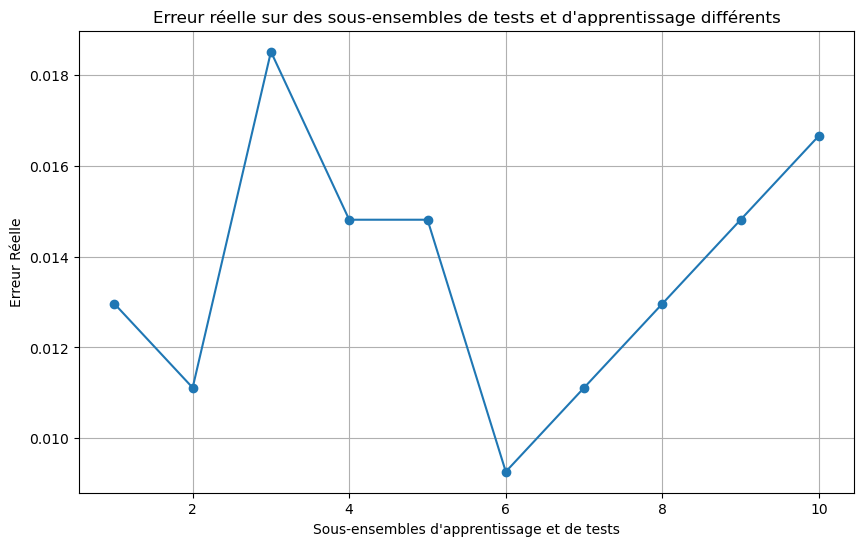

In [29]:
erreurs = []

for i in range(10):
    # Utilisation d'une valeur différente pour 'random_state' à chaque itération
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
    
    # Création du classifieur
    clf = KNeighborsClassifier(n_neighbors=3)
    clf.fit(X_train, y_train)
    
    # Calculer les prédictions
    predictions = clf.predict(X_test)
    
    # Calculer l'erreur d'apprentissage
    test_accuracy = accuracy_score(y_test, predictions)
    test_error = 1 - test_accuracy
    erreurs.append(test_error)
    
    print("Sous-ensemble = " + str(i+1) + ", erreur = " + str(test_error))

# Tracer la courbe
plt.figure(figsize=(10, 6))

# Générer la liste des indices des sous-ensembles
sous_ensembles = list(range(1, 11))  # De 1 à 10 pour représenter les 10 sous-ensembles

# Tracer l'erreur en fonction des sous-ensembles
plt.plot(sous_ensembles, erreurs, marker='o')

plt.xlabel("Sous-ensembles d'apprentissage et de tests")
plt.ylabel('Erreur Réelle')
plt.title("Erreur réelle sur des sous-ensembles de tests et d'apprentissage différents")
plt.grid(True)
plt.show()


## 5. Métrique de similarité entre voisins (optionnel)

Au delà du nombre de voisins, un autre hyper-paramètre est la métrique utilisée pour calculer la distance entre les exemples. Par défaut, la distance de Minkowski est utilisée, avec le paramètre $p=2$ qui indique que nous considérons la distance euclidienne. Avec $p=1$, nous aurions la distance de Manhattan. De façon générale, avec p>0, la distance utilisée est $l_p$ :

$$l_p(x, x')=(\sum_{i=1}^n |x_i - x'_i|^p)^{\frac{1}{p}}$$

**Question** Écrire un programme permettant de faire varier la distance dans l'algorithme des $k$ plus proche voisins (paramètre `p` de `nn.KNeighborsClassifier`), en faisant aussi varier $k$ de 1 à 25 comme dans l'exercice 3. Entraînez le classifieur sur l'ensemble d'entraînement, et estimez l'erreur réelle sur l'ensemble de test. Tracez 3 courbes sur un même plot (cf. doc de `plot` pour voir comment faire), une pour chaque valeur de $p$ parmi ${1,2,5}$, avec $k$ en abscisse et l'erreur réelle en ordonnée. Déduisez les valeurs optimales de $k$ et $p$ à partir de ce graphique.

In [ ]:
# a vous

## 6. Classification avec arbres de décision (à rendre dans rapport)

Les arbres de décision sont un autre type d'algorithme de classification permettant de prédire les classes de nouveaux exemples. Pour illustrer son implémentation dans scikit-learn, nous allons utiliser le jeu de données Iris, que nous diviserons également en deux sous-ensembles : entraînement et test.

In [30]:
from sklearn.datasets import load_iris  #importation de la commande
irisData = load_iris()
X = irisData.data
y = irisData.target
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=42)
print(Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape)

(75, 4) (75, 4) (75,) (75,)


On apprendra un classifieur à arbres de décision de la même façon que pour les $k$ plus proches voisins. Pour cela, on utilise la classe `sklearn.tree.DecisionTreeClassifier` et on `fit` sur les données d'entraînement. Les arbres de décision ont l'avantage de pouvoir être affichés pour qu'on puisse interpréter les règles de classification apprises automatiquement :

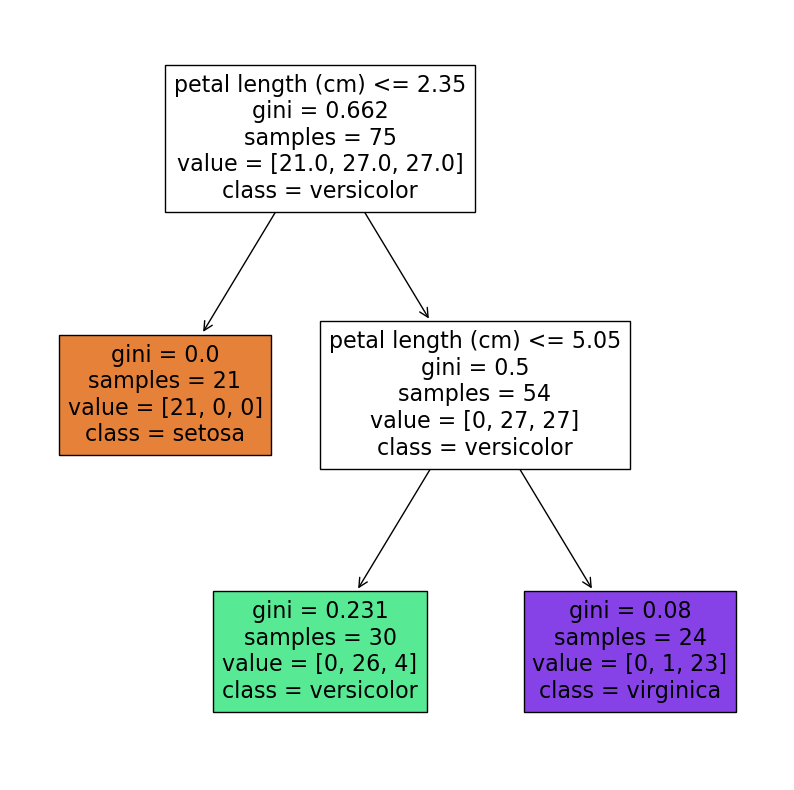

In [31]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

clf = DecisionTreeClassifier(random_state=42, max_depth=2)
clf.fit(Xtrain, ytrain)
plt.figure(figsize=(10,10))
plot_tree(clf, feature_names=irisData.feature_names, class_names=irisData.target_names, filled=True)
plt.show()

### 6.1 Stabilité des arbres de décision

**Question** Estimez sur l'ensemble de test l'erreur réelle du classifieur appris ci-dessus. Quel est le taux d'erreur obtenu ?

In [33]:
y_pred = clf.predict(Xtest)

accuracy = accuracy_score(ytest, y_pred)

error_rate = 1 - accuracy

# Affichage du taux d'erreur
print(f"Taux d'erreur sur l'ensemble de test : {error_rate:.4f}")

Taux d'erreur sur l'ensemble de test : 0.0667


**Question** Le paramètre `random_state` joue ici un rôle dans le choix des valeurs seuil à tester pour chaque attribut. Testez d'autres valeurs pour ce paramètre (p.ex. `random_state=2`) et observez l'arbre obtenu. Que se passe t-il ? Calculez aussi l'erreur réelle estimée sur l'ensemble de test - est-elle différente de celle obtenue avec `random_state=42` ? Pourquoi ?

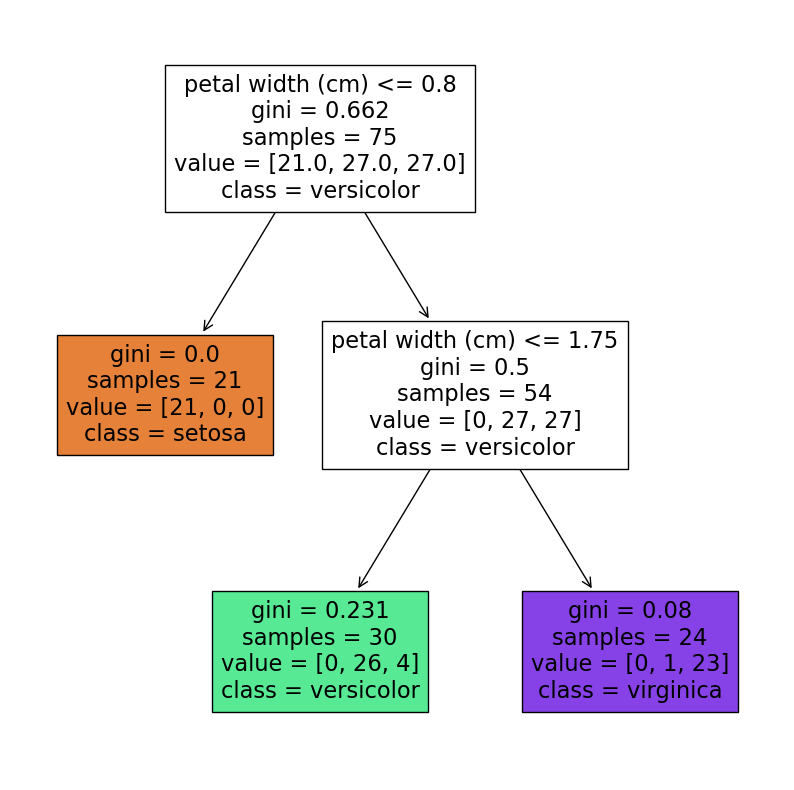

Taux d'erreur sur l'ensemble de test : 0.0133


In [41]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.5, random_state=42)
clf = DecisionTreeClassifier(random_state=2, max_depth=2)
clf.fit(Xtrain, ytrain)
plt.figure(figsize=(10,10))
plot_tree(clf, feature_names=irisData.feature_names, class_names=irisData.target_names, filled=True)
plt.show()
y_pred = clf.predict(Xtest)

accuracy = accuracy_score(ytest, y_pred)

error_rate = 1 - accuracy

# Affichage du taux d'erreur
print(f"Taux d'erreur sur l'ensemble de test : {error_rate:.4f}")

### 6.2 Hyper-paramètre : profondeur maximale de l'arbre

**Questions** L'hyper-paramètre `max_depth` contrôle la profondeur maximale de l'arbre. Modifiez le code ci-dessus pour tester la valeur `max-depht=5` au lieu de 2. Quel est l'impact de ce changement sur l’estimation de l’erreur réelle ?

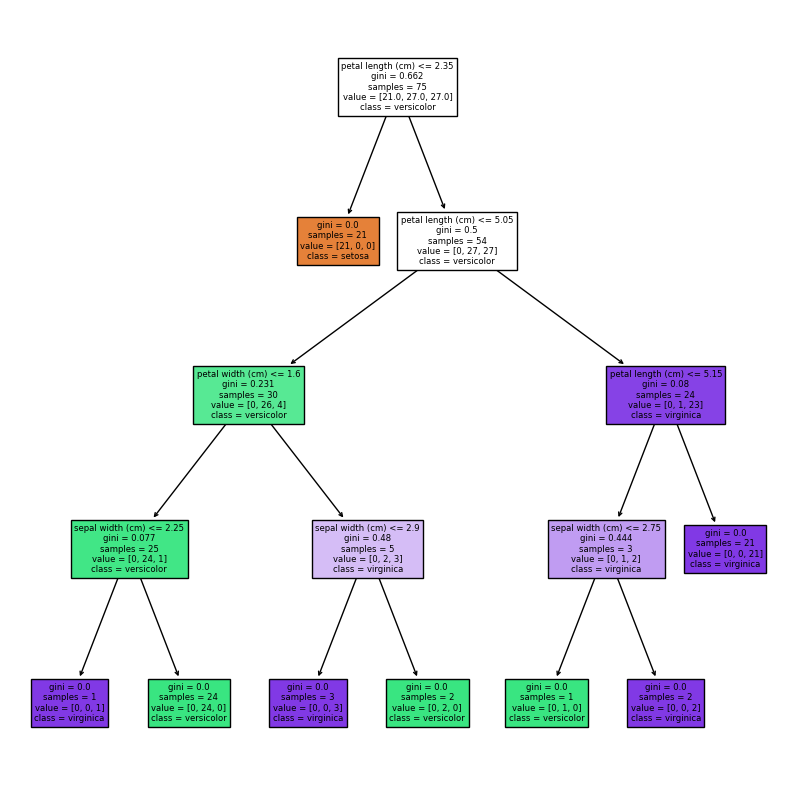

Taux d'erreur sur l'ensemble de test : 0.0933


In [42]:
clf = DecisionTreeClassifier(random_state=42, max_depth=5)
clf.fit(Xtrain, ytrain)
plt.figure(figsize=(10,10))
plot_tree(clf, feature_names=irisData.feature_names, class_names=irisData.target_names, filled=True)
plt.show()
y_pred = clf.predict(Xtest)

accuracy = accuracy_score(ytest, y_pred)

error_rate = 1 - accuracy

# Affichage du taux d'erreur
print(f"Taux d'erreur sur l'ensemble de test : {error_rate:.4f}")

### 6.3 Discrétisation des attributs

En cours, nous avons étudié les arbres de décision avec des attributs discrets, alors qu'ici nous avons 4 attributs numériques continus (nombre de centimètres). La bibliothèque scikit-learn utilise une stratégie pour trouver les valeurs des seuils dans les noeuds de l'arbre. Alternativement, on pourrait discrétiser le jeu de données avant d'apprendre le classifieur.

**Question** La classe `KBinsDiscretizer` vous aidera à transformer les données rapidement (cf. documentation). Encodez les données discrétisées avec des entiers (`encode='ordinal'`). Testez deux stratégies de discrétisation : `uniform` et `quantile`. Testez-les d'abord sur un vecteur d'exemple et expliquez la différence entre les deux stratégies.

In [36]:
from sklearn.preprocessing import KBinsDiscretizer

exemple = np.array([0.2, 0.3, 0.35, 0.36, 0.5, 0.6, 0.65, 9.1, 9.2]).reshape(-1,1)

# Discrétiseur avec la stratégie 'uniform'
kbins_uniform = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='uniform', subsample=None)

# Discrétiseur avec la stratégie 'quantile'
kbins_quantile = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile', subsample=200000)

# Appliquer les transformations
X_uniform = kbins_uniform.fit_transform(exemple)
X_quantile = kbins_quantile.fit_transform(exemple)

# Afficher les résultats
print("Données discrétisées avec la stratégie 'uniform':\n", X_uniform)
print("Données discrétisées avec la stratégie 'quantile':\n", X_quantile)

#'uniform' : Divise l'intervalle de données en segments de même largeur, ce qui peut conduire à des bins contenant des quantités très différentes de données.
#'quantile' : Divise les données de manière à ce que chaque bin contienne à peu près le même nombre de points, ce qui peut entraîner des intervalles de largeur variable.

Données discrétisées avec la stratégie 'uniform':
 [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [3.]
 [3.]]
Données discrétisées avec la stratégie 'quantile':
 [[0.]
 [0.]
 [1.]
 [1.]
 [2.]
 [2.]
 [3.]
 [3.]
 [3.]]


**Question** Discrétisez les 4 attributs de Iris en 3 catégories discrètes avec la méthode `uniforme`. Par exemple, imaginez que chaque longueur de pétale et de sépale, au lieu d'être exprimée en centimètres, serait catégorisée comme _0=petite_, _1=moyenne_ ou _2=grande_. Une fois les données transformées, séparéz-les à nouveau en deux sous-ensembles de taille identique. Ensuite, aprenez et visualisez un arbre de décision sur les données discrétisées et évaluez-le sur l'ensemble de test. Que peut-on observer par rapport à l'arbre appris sur les données originales ?

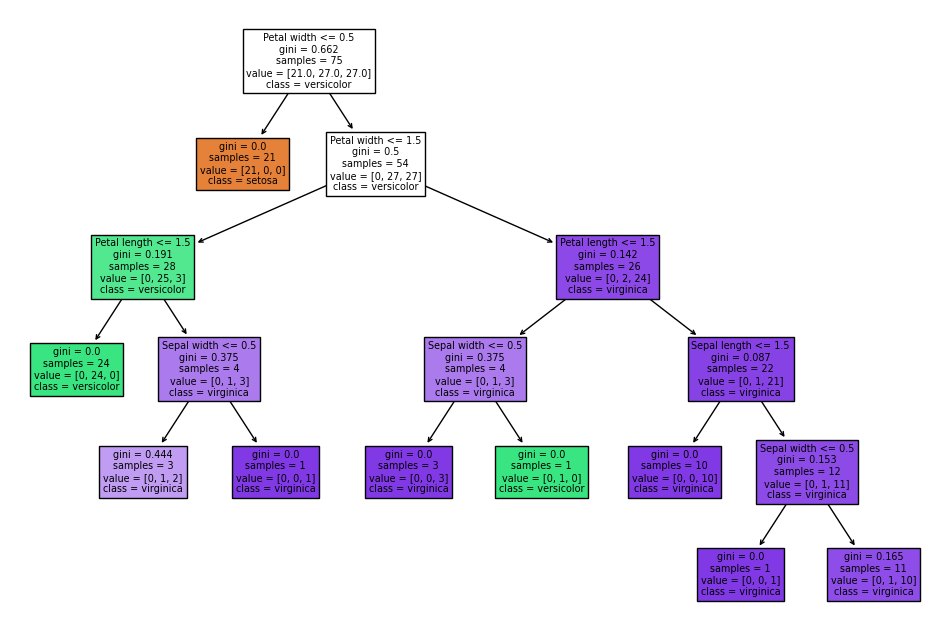

Accuracy sur l'ensemble de test : 0.97


In [37]:
from sklearn import tree
import pandas as pd


# Charger le jeu de données Iris
iris = load_iris()
X = iris.data
y = iris.target
feature_names = iris.feature_names
target_names = iris.target_names

# Discrétisation des données avec KBinsDiscretizer
discretizer = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform',subsample=None )
X_discretized = discretizer.fit_transform(X)

# Séparer les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_discretized, y, test_size=0.5, random_state=42)

# Apprentissage d'un arbre de décision
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Visualisation de l'arbre de décision
fig, ax = plt.subplots(figsize=(12, 8))
tree.plot_tree(clf, feature_names=['Sepal length', 'Sepal width', 'Petal length', 'Petal width'], class_names=target_names, filled=True, ax=ax)
plt.show()

# Évaluation de l'arbre sur l'ensemble de test
accuracy = clf.score(X_test, y_test)
print(f"Accuracy sur l'ensemble de test : {accuracy:.2f}")
